#  <font color='8caabe'>NLP Model that extracts names and forms relations:</font>

Possible Improvements:


*   Make the model suitable for compund sentences
*   Add more relationships
*   Clean up the code





### Pattern of a Compound Sentence:

    Name(s) > Relationship > Name(s) >
        i-> who > Relationship > Name[n+m+1] > ... > Name[n+m+o] .......
        ii-> and > Name(s) > Relationship > Name(s) ...........


This can go on for infinity, increasing the complexity of processing.

## Necessary Packages:

In [ ]:
import csv
import spacy
from spacy import displacy
from spacy.training import Example
from spacy.util import minibatch, compounding
import pandas as pd
from IPython.display import display, HTML
import networkx as nx
import matplotlib.pyplot as plt

# The Dataset
Since there is no Relationship dataset, we made our own in the folowing list:

In [ ]:
relationships = [
        'Father', 'Mother', 'Son', 'Daughter', 'Brother', 'Sister', 'Sibling', 
        'Grandfather', 'Grandmother', 'Grandson', 'Granddaughter',
        'Uncle', 'Aunt', 'Nephew', 'Niece', 'Cousin', 'Husband', 'Wife',
        'Partner', 'Fiance', 'Married', 'Parent'
    ]

## The NLP Model:

In [ ]:
# Load the English language model in spaCy
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Define the function to extract the names
def extract_names(text):
    global superdf
    # Parse the text with spaCy
    doc = nlp(text)
    
    # Loop through each sentence in the text
    for sent in doc.sents:
        sentence = sent.text.strip()
        sent_names = []
        sent_positions = []
        names_and = []
        df = pd.DataFrame(columns=['Member1', 'Member2', 'Relationship'])
        member1 = []
        member2 = []
        relation = []
        a = 0
        flag = 0
        

        # Loop through each token in the sentence
        for i, token in enumerate(sent):
            # Check if the token is a proper noun and its title is capitalized
            for rel in relationships:
                if rel.lower() in token.text.lower():
                    relation.append(rel)
                    flag = 1
            if token.pos_ == "PROPN" and token.text.istitle():
                # Add the name to the list of names and its position to the list of positions
                sent_names.append(token.text)
                a = a+1
                sent_positions.append(str(i+1))

                if flag == 0:
                  member1.append(token.text)
                else:
                  member2.append(token.text)

                # Find the names that are separated by "and"
                if a > 1 and (sent_names[a-2]+" and " + sent_names[a-1] in sentence):
                    names_and.append(sent_names[a-2])
                    names_and.append(sent_names[a-1])
        
        for mem1 in member1:
          for mem2 in member2:
            temp = [mem1, mem2, relation[-1]]
            df.loc[len(df.index)] = temp 
          
        # Merge all the dataframes:
        frames = [superdf, df]
        superdf = pd.concat(frames, ignore_index=True)

        # If names were found in the sentence, print them along with the sentence and their positions
        if sent_names:
            print(f"Sentence: {sentence}")
            print(f"Names: {', '.join(sent_names)}")
            print(f"Names separated by and: {', '.join(names_and)}")
            print(f"Relations: {', '.join(relation)}")
            print(f"Position: {', '.join(sent_positions)}\n")
            display(df)


Test Case:

In [ ]:
text = "John and Jerry are cousins with Jacob and Jack. Jack is the brother of Jacob. John is married to Jane. Jane is the mother of Emily"
superdf = pd.DataFrame(columns=['Member1', 'Member2', 'Relationship'])
extract_names(text)

Sentence: John and Jerry are cousins with Jacob and Jack.
Names: John, Jerry, Jacob, Jack
Names separated by and: John, Jerry, Jacob, Jack
Relations: Cousin
Position: 1, 3, 7, 9



,Member1,Member2,Relationship
0,John,Jacob,Cousin
1,John,Jack,Cousin
2,Jerry,Jacob,Cousin
3,Jerry,Jack,Cousin


Sentence: Jack is the brother of Jacob.
Names: Jack, Jacob
Names separated by and: 
Relations: Brother
Position: 1, 6



,Member1,Member2,Relationship
0,Jack,Jacob,Brother


Sentence: John is married to Jane.
Names: John, Jane
Names separated by and: 
Relations: Married
Position: 1, 5



,Member1,Member2,Relationship
0,John,Jane,Married


Sentence: Jane is the mother of Emily
Names: Jane, Emily
Names separated by and: 
Relations: Mother
Position: 1, 6



,Member1,Member2,Relationship
0,Jane,Emily,Mother


Saving the dataframe as a CSV file

In [ ]:
display(superdf)
# saving the dataframe
superdf.to_csv('family_tree.csv', index = False)

,Member1,Member2,Relationship
0,John,Jacob,Cousin
1,John,Jack,Cousin
2,Jerry,Jacob,Cousin
3,Jerry,Jack,Cousin
4,Jack,Jacob,Brother
5,John,Jane,Married
6,Jane,Emily,Mother


# The Visualization Model:

In [ ]:
def generate_family_tree(csv_file):
    # Create an empty graph using networkx
    G = nx.Graph()
    
    # Read the CSV file and add nodes and edges to the graph
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader) # skip header
        for row in reader:
            member1, member2, relation = row
            G.add_node(member1)
            G.add_node(member2)
            G.add_edge(member1, member2, relation=relation)
    
    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    edge_labels = {(u, v): d['relation'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

Output:

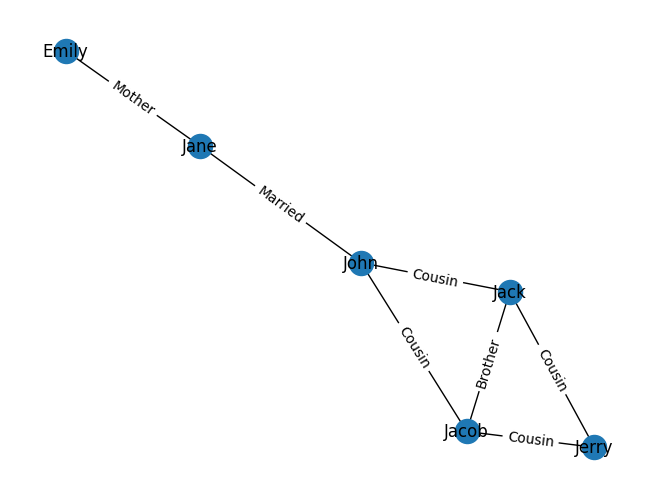

In [ ]:
generate_family_tree('/content/family_tree.csv')

# Potential Alternative: Using a custom Named Entity Recognition model on Spacy:

In [ ]:
# Load the English language model
nlp = spacy.load('en_core_web_sm')

# Split the string into different sentences
doc = nlp(text)
sentences = list(doc.sents)
print("NER output: ")
displacy.render(doc, style="ent", jupyter=True)

# Extract the Names of persons present in each sentence
for sentence in sentences:
    print("\n\t", sentence)
    persons = []
    for ent in sentence.ents:
       if ent.label_ == 'PERSON':
         persons.append(ent.text)
    if persons:
        print("\t>>> Persons in the sentence: ", persons)

NER output: 



	 John and Jerry are cousins with Jacob and Jack.
	>>> Persons in the sentence:  ['John', 'Jerry', 'Jacob', 'Jack']

	 Jack is the brother of Jacob.
	>>> Persons in the sentence:  ['Jack', 'Jacob']

	 John is married to Jane.
	>>> Persons in the sentence:  ['John', 'Jane']

	 Jane is the mother of Emily
	>>> Persons in the sentence:  ['Jane']


# Training Custom Relationship Data: 

In [ ]:
# Load an existing Spacy NER model
nlp = spacy.load("en_core_web_sm")

# Add a new label to the NER model
ner = nlp.get_pipe('ner')
ner.add_label('Relationship')

# Annotate training data with the custom label
train_data = [
    ('John is the father of Sarah.', {'entities': [(12, 18, 'Relationship')]}),
    ('Mary is the mother of Sarah.', {'entities': [(12, 18, 'Relationship')]}),
    ('John is the son of Sarah.', {'entities': [(12, 15, 'Relationship')]}),
    ('Mary is the daughter of Sarah.', {'entities': [(12, 20, 'Relationship')]}),
    ('John is the brother of Sarah.', {'entities': [(12, 19, 'Relationship')]}),
    ('Mary is the sister of Sarah.', {'entities': [(12, 18, 'Relationship')]}),
    ('John is the sibling of Sarah.', {'entities': [(12, 19, 'Relationship')]}),
    ('John is the grandfather of Sarah.', {'entities': [(12, 23, 'Relationship')]}),
    ('Anna is the grandmother of Sarah.', {'entities': [(12, 23, 'Relationship')]}),
    ('John is the grandson of Sarah.', {'entities': [(12, 20, 'Relationship')]}),
    ('Katy is the granddaughter of Sarah.', {'entities': [(12, 25, 'Relationship')]}),
    ('John is the uncle of Sarah.', {'entities': [(12, 17, 'Relationship')]}),
    ('Mary is the aunt of Sarah.', {'entities': [(12, 16, 'Relationship')]}),
    ('John is the nephew of Sarah.', {'entities': [(12, 18, 'Relationship')]}),
    ('Mary is the niece of Sarah.', {'entities': [(12, 17, 'Relationship')]}),
    ('John is the cousin of Sarah.', {'entities': [(12, 18, 'Relationship')]}),
    ('John is the husband of Sarah.', {'entities': [(12, 19, 'Relationship')]}),
    ('Mary is the wife of John.', {'entities': [(12, 16, 'Relationship')]}),
    ('John is the Sarah\'s partner.', {'entities': [(20, 27, 'Relationship')]}),
    ('John is the fiance of Sarah.', {'entities': [(12, 18, 'Relationship')]}),
    ('John is married to Sarah.', {'entities': [(8, 15, 'Relationship')]}),
    ('John is the parent of Sarah.', {'entities': [(12, 18, 'Relationship')]})
]

optimizer = nlp.resume_training()
n_iter = 10
batch_size = 4

# Train the model
for i in range(n_iter):
    losses = {}
    batches = minibatch(train_data, size=compounding(batch_size, 32, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        examples = [Example.from_dict(nlp.make_doc(text), annotation) for text, annotation in zip(texts, annotations)]
        nlp.update(examples, sgd=optimizer, losses=losses)
    print(f'Iteration {i}: Losses: {losses}')

Iteration 0: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 83.9586626471931}
Iteration 1: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 33.225415734795696}
Iteration 2: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 29.488280401273187}
Iteration 3: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 12.731044245494559}
Iteration 4: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.7182831872014503}
Iteration 5: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.008272777438264711}
Iteration 6: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0002698490704924339}
Iteration 7: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 1.8190491446024026e-05}
Iteration 8: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 1.370252141459291e-06}
Iteration 9: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 7.052292527882356e-07}


Checking if the class is added to the labels of entities:

In [ ]:
# Access the NER component and print the labels
ner = nlp.get_pipe('ner')
labels = ner.labels
print(labels)

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'Relationship', 'TIME', 'WORK_OF_ART')


Using the same example as before:

In [ ]:
doc = nlp(text)
displacy.render(doc, style="ent", jupyter=True)

### <font color='red'>Problems</font> with NER: 


1.   Names are very limited
2.   It misclassifies custom data easily (For example, in our case it misclassified 'Jacob' as a 'Relationship')

